# Project 3: Machine Learning C'25
### This is a standard image classification task designed to help everyone get fimiliar with the entire preocess of building up a machine learning project and understanding the key concepts and functions of its different components.

We will use PyTorch for the whole project. The Program Template is given, both py version and ipynb version.

# Import Packages

In [205]:
import os
import random

# data part
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split, Subset

# model part
import torch
import torch.nn as nn

# training & testing part
from tqdm.auto import tqdm

# evaluation & visualization part
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Get Dataset
## FER2013 Dataset: [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)
-

### For example code, we provide you how to load the training data into the dataloader which can be used to fit the model. Don't forget to download the data from Canvas and unzip it before you run the template.

### Do check the file address in case you don't keep the file structure which works for the template.
-

After getting the dataset, can use dataset.classes to get the class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'].

In [206]:
# This is a command line code for Jupyter Notebook to unzip file
# Please change the first address to the zip file path
# The second path is for the images folder
# !unzip -q fer_2013_train.zip -d ./

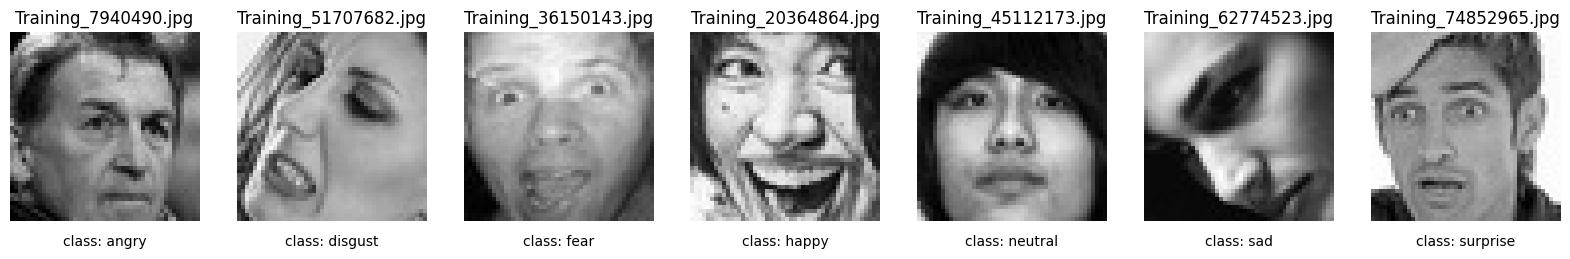

In [207]:
## If you want to show some image samples

# Image dir
image_dir = "./fer_2013_train/train"

# Images from all classes
class_folders = [folder for folder in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, folder))]

# Random pick 1 image from every class
num_images = len(class_folders)
selected_images = []

for class_name in class_folders:
  class_path = os.path.join(image_dir, class_name)
  image_files = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
  if image_files:
    selected_image = random.choice(image_files)
    selected_images.append((os.path.join(class_path, selected_image), class_name))

# Images show
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

for i, (img_path, img_class) in enumerate(selected_images):
    image = Image.open(img_path)
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")
    # File name
    axes[i].set_title(os.path.basename(img_path))
    # File size
    pos = axes[i].get_position()
    fig.text(pos.x0 + pos.width / 2, pos.y0 - 0.05, f"class: {img_class}",
             fontsize=10, ha="center")
plt.show()

# Transforms (*)
## For this part you need to try different transforms to get better classification results.
-
### Torchvision provides lots of image preprocessing utilities, we can use them as ways to get data augmentation.
### As you can see the samples above, the images have different sizes. We can use simple transforms to resize the PIL image and turn it into Tensor.
### Also, data augmentation can be done with transforms. You can use it to produce a variety of images, including rotation, scaling, flipping, color adjustments, and more.
-

Please check PyTorch official website for transforms details: [link](https://pytorch.org/vision/0.9/transforms.html)

In [208]:
# Usually we don't need augmentations in testing and also validation
# But we still need to resize the PIL image and transform it into Tensor
test_transforms = transforms.Compose([
    # Turn the image into grayscale (1 channel)
    transforms.Grayscale(num_output_channels=1),
    # Resize the image into a fixed shape (example for height = width = 128)
    # You may need to try different image sizes to find the size fits your model best
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # If you use normalization for the train_data, also need to normalize the test_data
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Use train_transforms to implement data augmentation
train_transforms = transforms.Compose([
    # Turn the image into grayscale (1 channel)
    transforms.Grayscale(num_output_channels=1),
    # Resize the image into a fixed shape (example for height = width = 128)
    # You may need to try different image sizes to find the size fits your model best
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(128, scale=(0.9, 1.0), ratio=(0.9, 1.1)),

    # ToTensor() should be the last one of the transforms
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Data Augmentation/Transforms Implementation Examples

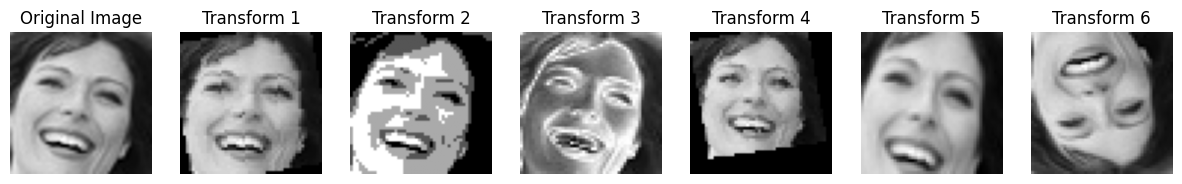

# Model (*)
## For this part you need to try different model structures to get better classification results. You can try different layer types, different number of layers, different activate functions, and etc.
-
### The default classification accuracy is around 0.3 which is better than the random guess, but looking at the training process, the model basically didn't learn anything.

In [209]:
class Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(Classifier, self).__init__()
        
        # You may have some your own layers here

        # self.layer_1 = ...
        # self.layer_2 = ...
        # self.layer_more = ...
        # ...
        # Feel free to experiment with different layer combinations.
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)

        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        self.layer_5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        self.layer_6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )


        self.layer_flatten = nn.Flatten()
        # For Linear output only, can use CrossEntropyLoss() for the loss (automatically apply Softmax)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc_layer_for_output = nn.Linear(1024*2*2, num_classes)
        # If you are using Linear + Sigmoid as the output layer, then BCELoss() can be used to get the loss
        # To know more about criterion, please check PyTorch official site

    # forward() defines how the input data flows through the layers of the model during the forward pass
    def forward(self, x):
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
        out_4 = self.layer_4(out_3)
        out_5 = self.layer_5(out_4)
        out_6 = self.layer_6(out_5)

        flattened = self.layer_flatten(out_6)
        flattened = self.dropout_fc(flattened)
        output = self.fc_layer_for_output(flattened)
        return output

# Configurations (*)
## Here is the part you can "control" the training process by setting your own hyperparameters, which might affect your model performance. Main hyperparameters include the data batch size, number of training epochs, the loss function, optimizer and etc.
-
### Please try sets of experiments with different combinations of hyperparameters to determine which goes best with your model.

In [210]:
# Check whether GPU is availbale and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Initialize the model, and don't forget to put it on the device
model = Classifier().to(device)

###########################################################################################
###########################################################################################
# You can try differnet configurations below for training the model to get better results #
###########################################################################################
###########################################################################################

# The number of batch size
batch_size = 32

# The number of training epochs
n_epochs = 50

# Set up the criterion, we usually use cross-entropy as the measurement of classification performance
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you can try different hyperparameters or different types of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

cuda


# Dataloader
## This is how PyTorch help you to load the data as a dataloader.
-
### For the template, we use the ImageFolder provided by torchvision.datasets to read the data with the folder annotations. YOu can also write you own data class to read the images and labels.
### For the template, we also use random_split from torch.utils.data to get the training and validation data. You can also try other data split methods such as train_test_split from sklearn and etc. The training and validation ratio can also be adjusted.
### Do not use the train_transforms for the validation data, since you may have some data augmentation operations for training data.
-

For more infomation about data and dataloader, please refer to the PyTorch website: [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders)

In [211]:
# Construct train datasets
# The argument "loader" tells how torchvision reads the data.
train_dir = "./fer_2013_train/train"

# We use ImageFolder to read the images and set the annotations for each image
# Do not use train_transforms for this step, since the validation data should not have data augmantation
full_train_dataset = ImageFolder(train_dir)

# Aligned with official dataset
original_class_to_idx = full_train_dataset.class_to_idx
desired_class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

new_class_to_idx = {cls_name: i for i, cls_name in enumerate(desired_class_order)}
full_train_dataset.class_to_idx = new_class_to_idx

full_train_dataset.samples = [
    (img_path, new_class_to_idx[original_cls_name])
    for img_path, original_cls_idx in full_train_dataset.samples
    for original_cls_name, idx in original_class_to_idx.items() if idx == original_cls_idx
]

# Construct valid datasets
# You can also use other methods like train_test_split() to get the validation set

# 80% training，20% validation
train_ratio = 0.8
train_size = int(train_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# random_split() by PyTorch
train_indices, val_indices = random_split(range(len(full_train_dataset)), [train_size, val_size])

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Set the transforms separately for training and validation data
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples: 22932, Validation samples: 5734


In [212]:
# You are encouraged to show some train and validation data and label to know better about your data.

# Training Process
## Show the whole training process including the validation part, and save model at the last step. Basically, you don't need to change anything for this part. However, you should know clearly about the whole process about how to train your model.
-

For more infomation about training a model, please refer to PyTorch website: [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#training-with-pytorch)



In [213]:
# Record the best validation acc to save the best model
best_acc = 0
train_epoch_accs = []
valid_epoch_accs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        # Automatically invokes the forward() method in your model class. 
        # Make sure your model has a properly defined forward() method to handle data flow.
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_epoch_accs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    scheduler.step(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    valid_epoch_accs.append(valid_acc)


    # save models
    if valid_acc > best_acc:
        save_path = "model_best.pth"
        print(f"Best model found at epoch {epoch+1}, saving model")
        torch.save(model.state_dict(), save_path)
        best_acc = valid_acc

  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 2.41465, acc = 0.21478


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 001/050 ] loss = 1.87784, acc = 0.25856
Best model found at epoch 1, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 2.29786, acc = 0.27041


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 1.81396, acc = 0.32928
Best model found at epoch 2, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 2.18741, acc = 0.36316


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 1.61905, acc = 0.41609
Best model found at epoch 3, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 2.02211, acc = 0.40890


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 004/050 ] loss = 1.38535, acc = 0.46875
Best model found at epoch 4, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 1.89695, acc = 0.43119


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 005/050 ] loss = 1.74374, acc = 0.46806


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 1.76598, acc = 0.45419


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 006/050 ] loss = 1.26033, acc = 0.51939
Best model found at epoch 6, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 1.58636, acc = 0.47407


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 007/050 ] loss = 1.26039, acc = 0.52830
Best model found at epoch 7, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 1.42064, acc = 0.49219


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 008/050 ] loss = 1.22186, acc = 0.54005
Best model found at epoch 8, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 1.30750, acc = 0.51435


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 009/050 ] loss = 1.19669, acc = 0.54699
Best model found at epoch 9, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 1.25377, acc = 0.53070


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 010/050 ] loss = 1.14352, acc = 0.56568
Best model found at epoch 10, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 1.22249, acc = 0.54118


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 011/050 ] loss = 1.14252, acc = 0.56256


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 1.20572, acc = 0.54455


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 1.12593, acc = 0.57269
Best model found at epoch 12, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 1.18606, acc = 0.55207


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 013/050 ] loss = 1.15406, acc = 0.56389


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 1.15875, acc = 0.56693


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 1.12195, acc = 0.57228


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 1.14750, acc = 0.57040


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 015/050 ] loss = 1.07105, acc = 0.59149
Best model found at epoch 15, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 1.13483, acc = 0.57560


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 1.07165, acc = 0.59479
Best model found at epoch 16, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 1.11512, acc = 0.58237


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 017/050 ] loss = 1.07374, acc = 0.59398


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 1.10048, acc = 0.58106


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 018/050 ] loss = 1.04751, acc = 0.60122
Best model found at epoch 18, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 1.08169, acc = 0.59563


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 019/050 ] loss = 1.07710, acc = 0.59444


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 1.07836, acc = 0.59771


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 020/050 ] loss = 1.05990, acc = 0.60365
Best model found at epoch 20, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 1.05848, acc = 0.60154


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 021/050 ] loss = 1.04358, acc = 0.60787
Best model found at epoch 21, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 1.05032, acc = 0.60680


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 022/050 ] loss = 1.10466, acc = 0.58929


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 1.03878, acc = 0.61009


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 023/050 ] loss = 1.06333, acc = 0.60440


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 1.02523, acc = 0.61725


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 024/050 ] loss = 1.01925, acc = 0.61591
Best model found at epoch 24, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 1.01466, acc = 0.61847


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 025/050 ] loss = 1.02850, acc = 0.61505


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 1.01568, acc = 0.61912


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 026/050 ] loss = 1.04353, acc = 0.60515


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 1.00920, acc = 0.62171


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 027/050 ] loss = 1.05203, acc = 0.60208


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 0.99575, acc = 0.62544


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 028/050 ] loss = 1.03159, acc = 0.61782
Best model found at epoch 28, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 0.93706, acc = 0.64766


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 029/050 ] loss = 0.98764, acc = 0.62830
Best model found at epoch 29, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 0.90253, acc = 0.66175


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 030/050 ] loss = 0.97791, acc = 0.63605
Best model found at epoch 30, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 0.88338, acc = 0.67145


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 031/050 ] loss = 0.98136, acc = 0.62992


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 0.87098, acc = 0.67239


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 032/050 ] loss = 0.99188, acc = 0.63200


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 0.85140, acc = 0.68002


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 033/050 ] loss = 0.97106, acc = 0.63981
Best model found at epoch 33, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 0.84663, acc = 0.68522


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 034/050 ] loss = 0.97842, acc = 0.63837


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 0.83709, acc = 0.68478


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 035/050 ] loss = 0.96462, acc = 0.64416
Best model found at epoch 35, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 0.82139, acc = 0.69289


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 036/050 ] loss = 0.96695, acc = 0.63767


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 0.81781, acc = 0.69015


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 037/050 ] loss = 0.96226, acc = 0.64259


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 0.79979, acc = 0.70002


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 038/050 ] loss = 0.96103, acc = 0.64358


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 0.79345, acc = 0.70545


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 039/050 ] loss = 0.95136, acc = 0.65133
Best model found at epoch 39, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 0.78401, acc = 0.70524


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 040/050 ] loss = 0.96736, acc = 0.64265


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 0.78057, acc = 0.70722


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 041/050 ] loss = 0.95460, acc = 0.64884


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 0.77271, acc = 0.70685


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 042/050 ] loss = 0.95764, acc = 0.64815


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 0.75786, acc = 0.71935


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 043/050 ] loss = 0.98557, acc = 0.63513


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 0.73049, acc = 0.72919


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 044/050 ] loss = 0.95206, acc = 0.64855


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 0.70015, acc = 0.73842


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 045/050 ] loss = 0.95132, acc = 0.65197
Best model found at epoch 45, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 0.68697, acc = 0.74343


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 046/050 ] loss = 0.94543, acc = 0.65301
Best model found at epoch 46, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 0.66958, acc = 0.75326


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 047/050 ] loss = 0.94796, acc = 0.65156


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 0.65589, acc = 0.75890


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 048/050 ] loss = 0.94384, acc = 0.65388
Best model found at epoch 48, saving model


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 0.64261, acc = 0.75847


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 049/050 ] loss = 0.94697, acc = 0.64959


  0%|          | 0/717 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 0.63610, acc = 0.76531


  0%|          | 0/180 [00:00<?, ?it/s]

[ Valid | 050/050 ] loss = 0.94419, acc = 0.65179


# Dataloader for Test
## We've used dataloader at the training phase, for testing part, the only difference is that we don't need to apply any data augmentation technique except for resize and ToTensor.
-
### We keep part of the test data and we’ll run your best performing model to determine its accuracy on our own test set.



In [214]:
# This is a command line code for Jupyter Notebook to unzip file
# Please change the first address to the zip file path
# The second path is for the images folder
# !unzip -q fer_2013_test.zip -d ./

In [215]:
# Construct test datasets
# The argument "loader" tells how torchvision reads the data.
test_dir = "./fer_2013_test/test"

# We use ImageFolder to read the images and set the annotations for each image
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# Aligned with official dataset
original_class_to_idx = test_dataset.class_to_idx
desired_class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

new_class_to_idx = {cls_name: i for i, cls_name in enumerate(desired_class_order)}
test_dataset.class_to_idx = new_class_to_idx

test_dataset.samples = [
    (img_path, new_class_to_idx[original_cls_name])
    for img_path, original_cls_idx in test_dataset.samples
    for original_cls_name, idx in original_class_to_idx.items() if idx == original_cls_idx
]

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testing Process
## This is the testing phase for verifying your model's performance. We need to load the best model you saved during the training phase with trained parameters. After we get the predictions by the model and true labels, we can use them to do the evaluations.
-

For more infomation about testing a model, please refer to PyTorch website: [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#training-with-pytorch)

In [216]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

save_path = "model_best.pth"
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(save_path))

model_best.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data, labels in tqdm(test_loader):
        model_output = model_best(data.to(device))
        predicted_label = torch.argmax(model_output, dim=1).cpu().numpy()

        predictions.extend(predicted_label)
        true_labels.extend(labels)



  0%|          | 0/112 [00:00<?, ?it/s]

# Evaluation & Visualizations (*)

### Training & Validation Performance Plot

The plot should show how training accuracy and validation accuracy change over time during training. Graph number of training epochs (x-axis) versus training set and validation set accuracy (y-axis). Hence, your plot should contain two curves.

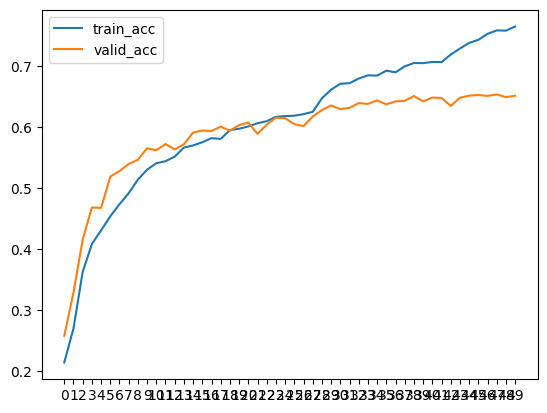

In [224]:
## Training & Validation Performance Plot
# The plot should show how training accuracy and validation accuracy change over time during training. 
# Graph number of training epochs (x-axis) versus training set and validation set accuracy (y-axis). 
# Hence, your plot should contain two curves.

# Convert the list of tensors to list of numpy arrays
train_epoch_accs_np = [x.cpu().numpy() for x in train_epoch_accs]
valid_epoch_accs_np = [x.cpu().numpy() for x in valid_epoch_accs]

# Plot the graph
plt.plot(train_epoch_accs_np, label='train_acc')
plt.plot(valid_epoch_accs_np, label='valid_acc')
plt.xticks(range(len(train_epoch_accs_np)))
plt.legend()
plt.show()

### Confusion Matrix
The matrix should be a 7-by-7 grid showing which categories of images were classified. Use your confusion matrix to additionally report precision and recall for each of the 7 classes, as well as the overall accuracy of your model.  

In [222]:
## Confusion Matrix
# The matrix should be a 7-by-7 grid showing which categories of images were classified. 
# Use your confusion matrix to additionally report precision and recall for each of the 7 classes, as well as the overall accuracy of your model.

#the built-in functions gave me errors
#type = all for total num examples
#type = row for sum of a row
#type = col for sum of a col
#k is the index of the row or col you want
def get_sum_examples(mtx, type, k=0):
    sum = 0
    if type == "all":
        for i in range(0,7):
            for j in range(0,7):
                sum = sum + mtx[i][j]

    if type == "row":
        for i in range(0,7):
            sum = sum + mtx[k][i]

    if type == "col":
        for i in range(0,7):
            sum = sum + mtx[i][k]

    return sum

def get_accuracy(mtx):
    sum = get_sum_examples(mtx, "all")
    acc_sum = 0
    for i in range(0,7):
        acc_sum = acc_sum + mtx[i][i]
    return acc_sum

def get_precision(mtx):
    precision_lst = []
    for i in range(0,7):
        temp = mtx[i][i]
        col_sum = get_sum_examples(mtx, "col", i)
        pre = temp/col_sum
        precision_lst.append(pre)
    return precision_lst

def get_recall(mtx):
    recall_lst = []
    for i in range(0,7):
        temp = mtx[i][i]
        row_sum = get_sum_examples(mtx, "row", i)
        pre = temp/row_sum
        recall_lst.append(pre)
    return recall_lst

Confusion_mtx = confusion_matrix(true_labels, predictions)
accuracy = get_accuracy(Confusion_mtx)
precision = get_precision(Confusion_mtx)
recall = get_recall(Confusion_mtx)
print(Confusion_mtx)
print(accuracy)
print(precision)
print(recall)

[[241   9  34  26 113  10  45]
 [ 11  34   1   2   7   1   0]
 [ 42   5 163  25 186  44  46]
 [ 12   0  12 770  36  12  44]
 [ 47   0  25  28 424   9  90]
 [  5   0  29  18  22 329  12]
 [ 21   1  15  53 155   4 366]]
2327
[0.6358839050131926, 0.6938775510204082, 0.5842293906810035, 0.8351409978308026, 0.4496288441145281, 0.80440097799511, 0.6069651741293532]
[0.50418410041841, 0.6071428571428571, 0.31898238747553814, 0.8690744920993227, 0.680577849117175, 0.7927710843373494, 0.5951219512195122]


### Misclassified Image Visualization
Include 3 visualizations of images that were misclassified by your best-performing model. You will have to create or use a program that get the misclassified images and translate it into a grayscale image and show.



In [ ]:
# Your code to implement